# Lesson 4: Quantifying Uncertainty

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/04_Quantifying_Uncertainty.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Review of model fitting
- Bayes Factor for model comparison
- Introduce Bayesian approaches
- How to solve it... MCMC!
- Metropolis-Hastings
- Code MCMC
- Validate MCMC
- Bayesian t-test example


## Maximum Likelihood / Bayes Factor approach

Last class we learned that we can calculate parameters that maximize the likelihood of observing the data given the model and those parameters:

$$\hat{L} = P(D \mid \hat{\theta}, M)$$

However, this approach ignores the fact that there are many parameter values that *could* have generated the same data.


## Bayesian Inference

Instead, what we'd really like to know is the full set of possible parameters given the data:

$$P(\theta \mid D)$$

This should look familiar and a probability reminder should give a hint for how to calculate it...

## Probability reminder

### A and B
$$P(A \cap B) = P(A \mid B) P(B) = P(B \mid A) P(A)$$

### A given B 
$$P(A \mid B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B \mid A) P(A)}{P(B)}$$


## Bayes Rule

$$P(\theta \mid D) = \frac{P(\theta \cap D)}{P(D)} = \frac{P(D \mid \theta) P(\theta)}{P(D)} \propto P(D \mid \theta) P(\theta)$$

- $P(\theta \mid D)$ is the posterior probability
- $P(D \mid \theta)$ is the likelihood
- $P(\theta)$ is the prior probability
- $P(D)$ is the marginal likelihood (*does not depend on model or params*)

## What's a prior?

A prior probability represents the initial belief in the potential values of some quantity before any new evidence is taken into account.

The notion of a prior is one of the key differences between Bayesian and Frequentist approaches. Bayesians believe that we should take such prior knowledge into account when making decisions and that this prior knowledge can be updated with each new bit of evidence:

"Today's posterior is tomorrow's prior"

That said, priors are also a major critique of Bayesian approaches because they can have a massive effect on the posterior (i.e., the conclusions you draw).

## Bayesian Inference

Determining $P(\theta \mid D)$ can be difficult for a number of reasons:

- The posterior of a model given the data is rarely known analytically
- The likelihood $P(D \mid \theta)$ is often intractable, requiring simulation
- Can be unfeasible/impossible to determine the marginal likelihood ($P(D)$)

The standard approach is to use Markov chain Monte Carlo (MCMC) to estimate the posterior.


## MCMC - Metropolis Hastings algorithm

The basic idea is that if you take repeated samples of the space of a known function that is *proportional* to the posterior, then you will eventually gain a reasonable estimate of that probability distribution.

The basic steps are as follows:

0. Initialize a starting parameter set with a non-zero likelihood
1. Generate a parameter proposal
2. Calculate likelihood for that proposal
3. Compare with the previous parameter and decide whether to accept it
4. Repeat steps 1--3 until you have a stable estimate of the posterior

## 0. Initializing the chain

Before we can start exploring the posterior we have to get a starting set of parameter values ($\theta_0$) with a non-zero likelihood. 

The most common way of doing this is to sample randomly from the priors for each parameter and evaluate the model likelihood, repeating until you find parameter set that has a non-zero likelihood.

## 1. Proposal generation

The key to generating a Markov chain is that each proposal must depend *only* on the current state. 

Furthermore, in order to properly sample the entire space of the posterior function, these proposals must be *symmetric*. This means that the probability of generating a specific parameter set based on the current state must equal the probability of generating the current parameters given the proposal. 

This is also referred to as a symmetric transition probability.

There are many ways to generate symmetric proposals, but the easiest (and least efficient) is to draw from a normal distribution centered on each current parameter value.

## 2. Likelihood calculation

Once you have a proposed parameter set, you must calculate the likelihood of observing the data given those parameter values and your model. 

This is identical to what we have done before when calculating the maximum likelihood via gradient descent. 

Your model can be any function, from a probability distribution to a large-scale cognitive model, so long as you can return a log likelihood.

## 3. Acceptance ratio

Once you've evaluated the likelihood of observing the data given your parameters, you need to decide whether this parameter proposal is worth keeping. Here we calculate a probability of accepting the proposal based on the ratio of posterior probability values:

$$P(\text{accept}) = \frac{P(D \mid x') P(x')}{P(D \mid x_i) P(x_i)},$$

where $x'$ is the parameter proposal and $x_i$ is the current parameter at iteration $i$. Note that we can ignore the denominator of the posterior probability function, $P(D)$ because it cancels out in the ratio.

Then you simply draw a uniform random number between $[0, 1)$, and if that value is less than the acceptance probability you accept the proposal and replace the current value, otherwise you copy the current state of the parameters to the new state.

## *ONLY* if on Google Colab


In [ ]:
# to retrieve the dists.py and data files
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/dists.py

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import dists

In [2]:
# function for generating proposals
def gen_proposal(x, std=0.1):
    # use normal distribution centered at current value
    # to generate new value
    # loops over each parameter in the set
    x_new = [dists.normal(mean=x[i], std=std).rvs()
             for i in range(len(x))]
    
    # convert from list to array and return
    return np.array(x_new)

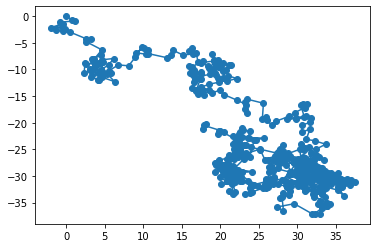

In [3]:
# explore the proposal generation random walk
# start at 0,0
props = [np.array([0., 0.])]

# generate 50 sequential proposals
for i in range(500):
    # call proposal gen with the last proposal
    props.append(gen_proposal(props[-1], std=1.))

# convert list of arrays into an array
props = np.array(props)

# plot the random walk
plt.plot(props[:,0], props[:,1], 'o-');

# what happens when you adjust the std?

In [4]:
# Provide way to evaluate the prior
def eval_prior(x, priors):
    # make sure we can loop through it
    x = np.atleast_1d(x)
    
    # loop over each param and associated prior, calculating the PDF
    return np.array([np.log(priors[i].pdf(x[i])) 
                     for i in range(len(x))]).sum()

In [5]:
priors = [dists.normal(10.0, 0.5),
          dists.uniform(-5, 5)]
eval_prior([10, -2], priors)

-2.5283764456387727

In [6]:
# MCMC!!!
def MCMC(like_fun, x0=None, args=None, priors=None, niter=10000, std=0.1):  
    # process the args
    if args is None:
        args = ()
        
    # 0. get starting point
    if x0 is None:
        # draw from the priors
        x0 = [priors[i].rvs() for i in range(len(priors))]
        ll0 = like_fun(x0, *args)
        while np.isnan(ll0) or np.isinf(ll0):
            x0 = [priors[i].rvs() for i in len(priors)]
            ll0 = like_fun(x0, *args)
    else:
        # eval the starting point
        ll0 = like_fun(x0, *args)
        if np.isnan(ll0) or np.isinf(ll0):
            raise ValueError('The starting point has a zero likelihood.')
            
    print('Starting point:', x0)
    print('Log Like:', ll0)

    # initialize the chain and associated likelihood
    chain = [x0]
    log_like = [ll0]

    # sample from the posterior
    for i in range(niter):
        # 1. generate a new proposal from the last accepted params
        x_new = gen_proposal(chain[-1], std=std)

        # 2. evaluate that new proposal
        ll_new = like_fun(x_new, *args)

        # 3. calculate the acceptance ratio
        accept_ratio = np.exp(ll_new - log_like[-1])

        # see if we should use priors
        if priors is not None:
             accept_ratio *= np.exp(eval_prior(x_new, priors) - 
                                    eval_prior(chain[-1], priors))

        # decide whether to keep the proposal, or copy the previous
        if (accept_ratio > 1.0) or (np.random.rand() < accept_ratio):
            # accept it
            chain.append(x_new)
            log_like.append(ll_new)
        else:
            # repeat the previous
            chain.append(chain[-1])
            log_like.append(log_like[-1])

    # convert the chain and log_likes to arrays
    chain = np.array(chain)
    log_like = np.array(log_like)
    
    return chain, log_like

## Validate MCMC on known function

In [7]:
# likelihood function
def like_fun(x, *args):
    # evaluate the model given the params
    # in this case the params are the points where we're evaluating the model
    return np.log(dists.normal(-.5, 0.5).pdf(x))

# define some priors (or not)
#priors = [dists.normal(2.0, 1)]
priors = None

chain, log_like = MCMC(like_fun, x0=[0.0], priors=priors, niter=10000)

Starting point: [0.0]
Log Like: [-0.72579135]


Text(0, 0.5, 'Value')

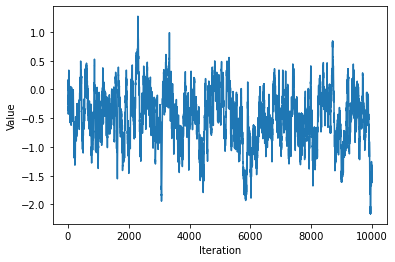

In [8]:
# plot the chain through time
plt.plot(chain[:,0])
plt.xlabel('Iteration')
plt.ylabel('Value')

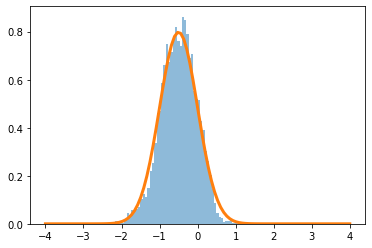

In [10]:
# plot the estimated and true posterior
burnin = 100
x = np.linspace(-4,4,100)
plt.hist(chain[burnin:], bins='auto', density=True, alpha=.5);
plt.plot(x, np.exp(like_fun(x)), '-', lw=3)
if priors is not None:
    plt.plot(x, priors[0].pdf(x), '-', lw=3)


## Explore the effects of priors

Go back up and try various priors and see how it affects the posterior.

## Bayesian Estimation Supersedes the t-Test (BEST)

Why be just good when you could be the BEST?



Ttest_1sampResult(statistic=1.5521414839589645, pvalue=0.1550443684873528)

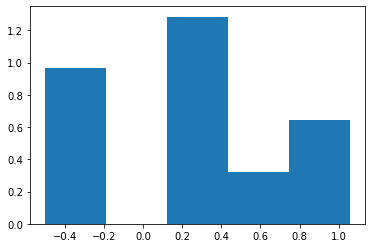

In [11]:
# generate some data that may or may not be significantly different from zero
A = dists.normal(mean=0.3, std=0.5).rvs(10)

# plot it
plt.hist(A, bins='auto', density=True);

# do a quick t-test
stats.ttest_1samp(A, 0.0)

In [12]:
# set up priors for mean, std, and df of Student's T
priors = [dists.normal(A.mean(), A.std()*2.0),
          dists.uniform(0.01, 10.),
          #dists.exp(1/29.)
         ]

Text(0.5, 1.0, 'Std Prior')

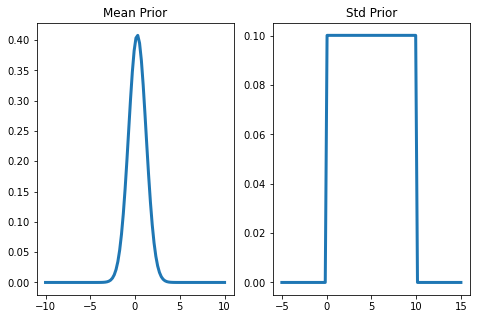

In [13]:
# plot those priors
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
x = np.linspace(-10, 10, 100)
plt.plot(x, priors[0].pdf(x), lw=3)
plt.title('Mean Prior')

plt.subplot(1, 3, 2)
x = np.linspace(-5, 15, 100)
plt.plot(x, priors[1].pdf(x), lw=3)
plt.title('Std Prior')

#plt.subplot(1, 3, 3)
#x = np.linspace(0, 50, 100)
#plt.plot(x, priors[2].pdf(x), lw=3)
#plt.title('Df Prior')


In [14]:
def ttest_like_fun(x, *args):
    # process the args
    obs = args[0]
    
    # evaluate the model given the params
    return np.log(dists.students_t(mean=x[0], 
                                   std=x[1], 
                                   df=len(obs)-1.).pdf(obs)).sum()


In [15]:
# run MCMC
chain, log_like = MCMC(ttest_like_fun, x0=None, args=(A,), 
                       priors=priors, niter=10000)

Starting point: [0.8875524336366672, 5.864528149804201]
Log Like: -27.259254247637045


In [16]:
chain.shape

(10001, 2)

Text(0, 0.5, 'Value')

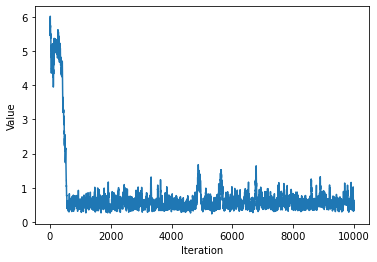

In [17]:
# plot the chain through time
plt.plot(chain[:,1])
plt.xlabel('Iteration')
plt.ylabel('Value')

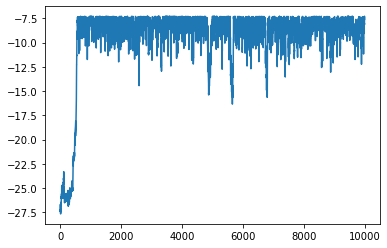

In [18]:
plt.plot(log_like)

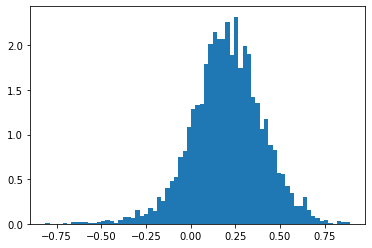

In [19]:
burnin = 1500
plt.hist(chain[burnin:,0], density=True, bins='auto');

## There's got to be a better way...

Next class we'll explore how we can use existing libraries to do the hard work for us...